# Coffea processors

Previously, we have only been working with awkward arrays constructed from a
single file. Coffea processers is the tool provided to scale up the
calculations to arbitrary file counts. The official [coffea-by-example
documentation](https://coffeateam.github.io/coffea/notebooks/processor.html) on
this topic actually is a very complete a tutorial on how you can get started.
But for the sake of the completion of this document, we will be including our
own version of the tutorial, to most of the gritty details filtered out. 

## A very simple processor -- understanding output

Let's first take a look at a very simple processor that takes work flow
described in the final analysis in simple calculation page, and translate into
awkward syntax:

In [1]:
from coffea import processor,hist
import numpy as np
import awkward1 as ak


class DummyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "nevent" : processor.defaultdict_accumulator(float),
            "invpt_sum": processor.defaultdict_accumulator(float),
            "hist": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("invpt", "$1/p_{T}$ [1/GeV]", 20, 0.01, 0.02),
                hist.Bin("eta",'$\eta$',20,-1,1)
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self,events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']

        # The object selection
        selectedMuon = events.Muon[ (events.Muon.pt > 50) & 
                                    (np.abs(events.Muon.eta)<2.4) ]
        selectedMuon['invpt'] = 1/selectedMuon.pt
        events['selectedMuon'] = selectedMuon

        # Event selection 
        events = events[ak.count(events.selectedMuon.pt,axis=-1) >= 1]

        # Filling the accumulator 
        output['nevent'][dataset] += len(events)
        output['invpt_sum'][dataset] += ak.sum(events.selectedMuon.invpt)
        output['hist'].fill( dataset=dataset, 
                              invpt=ak.flatten(events.selectedMuon.invpt),
                              eta=ak.flatten(events.selectedMuon.eta) )
        
        # returning the output 
        return output


    def postprocess(self, accumulator):
        return accumulator




The selection/filtering part of the `DummyProcessor.process` is basically
entirely the same as the using awkward examples without processors class,
except this time, the events have an additional `metadata` tag that can be used
to identify dataset name.

The main difference is in the output parts of the processor. Here the return is
what is known as `accumulator` classes defined the `coffea.processor`. Basically
each object that is defined within the various accumulators will be added up
across the multiple jobs that the processor instance will be run on. In our
case, we have two floating points that will be summed across multiple jobs, and
a histogram with 3 axes: 1 being what the data is, the other 2 being some
variables of interest. The filling of the histogram uses python keywords to
simplify the filling variable assignment. All argument in the fill command have
to have compatible dimensions, in our case:
- dataset has exactly dimension 1
- `ak.flatten()` reduces that `NxA` structure of electron variables to a simple
  `L`-lengthed array, the array inputs `invpt` and `eta` must have matching
  dimensions.

One can create a processor, and run on a single file for testing. (Again, if
you are running this tutorial notebook as is, remember to download the provided
data and schema files using the commands):

```sh 
cd   <WORKINGDIRECTORY>
wget https://raw.githubusercontent.com/UMDCMS/CoffeaTutorial/main/samples/dummy_nanoevents.root 
wget https://raw.githubusercontent.com/UMDCMS/CoffeaTutorial/main/samples/dummyschema.py
```

This will help use get a feel of what the output data is like:

In [2]:
from coffea.nanoevents import NanoEventsFactory 
from coffea.nanoevents.schemas import NanoAODSchema

events = NanoEventsFactory.from_root( 'file:TTbar.root' ,
                                      'Events',
                                      entry_stop=50,
                                      metadata={"dataset": "Dummy"}, 
                                      # Processors expects new meta data 
                                      schemaclass=NanoAODSchema,
).events()

p = DummyProcessor() 
output = p.process(events)

## Exploring the output
print(output['nevent'])
print(output['invpt_sum'])
print(output['hist'])

defaultdict_accumulator(<class 'float'>, {'Dummy': 3.0})
defaultdict_accumulator(<class 'float'>, {'Dummy': 0.054097119718790054})
<Hist (dataset,invpt,eta) instance at 0x7efefbf81430>


For typical analysis work, the most import object to futher explore is the
plotting of the histogram objects.  Again the [official
tutorial](https://coffeateam.github.io/coffea/notebooks/histograms.html) has
excellent pages on the manipulations of the `coffea.hist` objects. Here I will
just use a couple of basic examples for those who are just getting ready to
explore coffea:

Notice how categorical axis are automatically used as the various labeling, 


<Hist (dataset,invpt,eta) instance at 0x7efefbf81430>
<Hist (dataset,invpt) instance at 0x7f00a40c8a60>


<AxesSubplot:xlabel='$1/p_{T}$ [1/GeV]', ylabel='Events'>

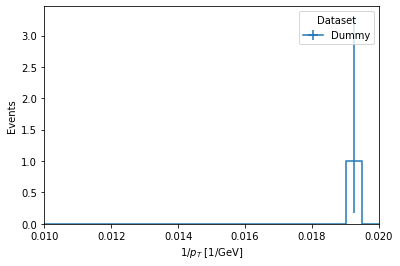

In [3]:
import matplotlib.pyplot as plt

print(output['hist'])
print(output['hist'].integrate('eta'))
hist.plot1d(output['hist'].integrate('eta'))

Notice how `integrate` can be used to reduce the dimensions of a histograms. You
can also provide a custom integration range if you want to perform additional
selections on binned dataset. Also

<AxesSubplot:xlabel='$\\eta$', ylabel='Events'>

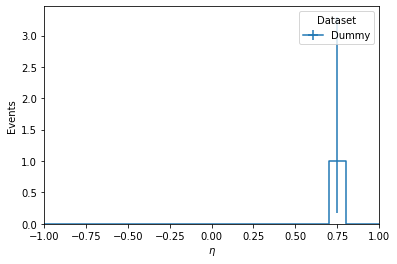

In [4]:
hist.plot1d(output['hist'].integrate('invpt', slice(0.015,0.020)))

## Scaling up calculations -- process executors

Suppose you have some file set, you can define coffea to run over all file with
a given metadata tag using the following 


In [5]:
output = processor.run_uproot_job(
    {
        'Dataset1': ['TTbar.root'],
        'Dataset2': ['TTbar.root', 'TTbar.root']
    },
    treename="Events",
    processor_instance=DummyProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": NanoAODSchema, "workers": 10},
)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/192 [00:00<?, ?chunk/s]

Now at first glance this seems to be a very straight forwards translation to
the form what we already have in the `NanoEventsFractory` method. The magic
statement that give coffea simple scalability is the use of the `executor`
argument. By using the
[processor.futures_executor](https://coffeateam.github.io/coffea/api/coffea.processor.futures_executor.html#coffea.processor.futures_executor),
you have already enabled local multithreading with a maximum of 10 parallel
threads, by doing so, we have just showed through nearly 10 gigabytes of data in
less than 5 seconds! Aside from the futures_executor. There is also the
[iterative_executor](https://coffeateam.github.io/coffea/api/coffea.processor.iterative_executor.html)
for single thread processing, which is the best for analysis debugging, since
    parallelism would cause the error messages to be wrapped in additional
    thread-related messages. There is also the
    [dask_executor](https://coffeateam.github.io/coffea/api/coffea.processor.dask_executor.html),
    which submits job to the grid computing resource available to machine
    running the notebook. If you already have the settings stored somewhere on,
    you can switch from a debugging to grid-level parallel programming simply by
    changing a couple of lines in the notebook! Examples of the configuration
    required to run grid-level parallelism can be found in the example
    [snippets](../snippets.rst).

A couple of notes on how parallelism works on the various executors: it is
still file-based (i.e. each file generates their own events awkward array to
be processed), so be careful that when running the `futures_executor` during
moderate testing you don't saturate memory usage of your local machine. Because
of this, if you create a histogram to keep a tally of `len(events)`, what you
would get is not a single number of events for each sample, but rather the
various number of events stored in each file. While it might be conceptually
helpful to think abstractly that the input `events` object to the `process`
method is a massive awkward array that spans the entire data set, this is not
how the processor is actually working.

Also, now we can comment on how process `accumulator` are performed across
multiple jobs. The contents of each of the accumulator instances are added
together via the `__sum__` operator. For `coffea.hist` histogram, this method
is already overloaded to behave how one would expect histogram aggregation to
work, but you can supply your own class with the `__sum__` operator overloaded
if you really want. Right now, there is **no** standard class to aggregate
    unbinned data, since the unbinned data can be arbitrarily large, so in a
    grid-level computation settings one would want to keep the unbinned data on
    each worker node until they are called by the main thread for further
    processing, as returning all data to the main thread will likely saturate
    all resources on a single machine. The core developers are currently
    [working](https://github.com/CoffeaTeam/coffea/pull/368) on this general
    use case which uses a different data format, but if you know that your
    final output data frame is expected to be small (ex you have a very tight
    background rejection selection), you can write your own accumulator class
    to get unbinned data.